In [1]:
import sys
workPath = '/home/jovyan/workspace'
if not workPath in sys.path:
    sys.path.append(workPath)

In [2]:
import planetengine
outputPath = planetengine.paths.make_testdir()

In [3]:
system = planetengine.tests.testsystems.get_system()

Fitted 1 variables to the figure.


In [4]:
from planetengine import functions as pfn

In [9]:
vector_component_funcs = [
    pfn.Component.ang,
    pfn.Component.rad
    ]

scalar_gradient_funcs = [
    pfn.Gradient.mag,
    pfn.Gradient.ang,
    pfn.Gradient.rad
    ]

scalar_surface_funcs = [
    pfn.Surface.outer,
    pfn.Surface.inner,
    ]

scalar_quantile_funcs = [
    lambda var: pfn.Select(
            var,
            float(x)
            ) \
        for x in range(1, 4)
    ]

scalar_reduction_funcs = [
    pfn.Integral.auto,
    pfn.GetStat.mins,
    pfn.GetStat.maxs
    ]

def var_expander(varList, funcList):
    outList = [func(var) for func in funcList for var in varList]
    for item in outList:
        print(item.opTag)
    return outList

def make_obsVars_var(inVar):

    obsVars = []
    inVar = pfn.convert(inVar)

    if inVar.varDim == 1:
        compVars = []
        baseVar = inVar
    elif inVar.varDim == 2:
        component_funcs = vector_component_funcs
        compVars = var_expander([inVar,], component_funcs)
        baseVar = pfn.Component.mag(inVar)
    else:
        raise Exception

    gradient_funcs = scalar_gradient_funcs
    gradVars = var_expander([baseVar, *compVars], gradient_funcs)

    surface_funcs = [
        func \
            for index, func in enumerate(scalar_surface_funcs) \
                if baseVar.bounds[0][index] == '.'
        ]
    surfVars = var_expander([baseVar, *gradVars], surface_funcs)

    quantile_funcs = scalar_quantile_funcs
    quantVars = var_expander(
        [pfn.Quantiles.terciles(var) for var in [baseVar, *surfVars]],
        quantile_funcs
        )

    reduction_funcs = scalar_reduction_funcs
    redVars = var_expander([baseVar, *quantVars], reduction_funcs)

    obsVars = redVars

    return obsVars

def make_obsVars_dict(varDict, return_dict = False):
    varDict = pfn.convert(varDict)
    obsVars = []
    for varName, inVar in sorted(varDict.items()):
        obsVars.extend(
            make_obsVars_var(inVar)
            )
    if return_dict:
        return make_dict_obsVars(obsVars)
    else:
        return obsVars

def make_dict_obsVars(obsVars):
    varDict = {}
    for var in obsVars:
        varDict[var.varName] = var
    return varDict

In [ ]:
obsDict = make_obsVars_dict(system.obsVars, return_dict = True)

In [ ]:
system.go(10)

In [ ]:
for key, val in sorted(obsDict.items()):
    print(key, val.evaluate())

In [ ]:
import planetengine

class Observer(planetengine._built.Built):

    def __init__(
            self,
            args,
            kwargs,
            inputs,
            script,
            _attach,
            _prompt,
            ):

        self._prompt = _prompt
        self._attach = _attach

        super().__init__(
            args = args,
            kwargs = kwargs,
            inputs = inputs,
            script = script
            )

    def attach(self, system):

        assert hasattr(system, 'initials'), \
            "System must have initials set."

        builts = {
            'observer': self,
            'observed': {
                'system': system,
                'initials': system.initials
                }
            }

        saveVars, saveFigs, saveCollectors = \
            self._attach(system)

        for sub in self.subs:
            sub_saveVars, sub_saveFigs, sub_saveCollectors = \
                sub._attach(system)
            saveVars.extend(sub_saveVars)
            saveFigs.append(sub_saveFigs)
            saveCollectors.append(sub_saveCollectors)

        checkpointer = checkpoint.Checkpointer(
            step = system.step,
            modeltime = system.modeltime,
            saveVars = saveVars,
            figs = saveFigs,
            dataCollectors = saveCollectors,
            builts = builts
            )

        self.system = system
        self.initials = system.initials
        self.builts = builts
        self.saveVars = saveVars
        self.figs = figs
        self.collectors = collectors
        self.checkpointer = checkpointer

    def prompt(self):
        self._prompt()

    def checkpoint(self, path = '', clear = True):
        self.checkpointer.checkpoint(path)
        if clear:
            for collector in self.saveCollectors:
                collector.clear()

In [ ]:
import planetengine
from planetengine import functions as pfn

def build(*args, name = None, **kwargs):
    built = Standard(*args, **kwargs)
    if type(name) == str:
        built.name = name
    return built

class Standard(Observer):

    script = 'test' # __file__

    def __init__(
            self,
            *args,
            **kwargs
            ):

    inputs = locals().copy()

    super().__init__(
        args,
        kwargs,
        inputs,
        script,
        self._attach,
        self._prompt
        )

    def _attach(self, system):

        varDict = {}

        obsVars = pfn.convert(system.obsVars)

    :
        
        

    def _prompt(self):
        pass

In [7]:
baseVar = pfn.convert('temperature', system.temperatureField)
quantVar = pfn.Quantiles.terciles(baseVar)
myVar = pfn.HandleNaN.zero(pfn.Select(quantVar, 2., baseVar))

Fitted 1 variables to the figure.
HandleNaN{Select{Quantiles_ntiles=3{Variable_varName=temperature{}};Constant_val=arr{[ 2.]}{};Variable_varName=temperature{}};Constant_val=arr{[ 0.]}{}}



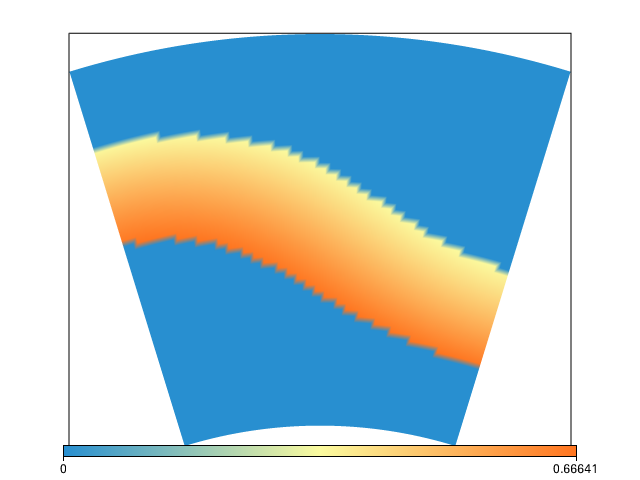

In [8]:
planetengine.quickShow(myVar)

In [ ]:
import underworld as uw
from underworld import function as fn
import math
import time
import glucifer
import numpy as np
import math

from . import utilities
from . import analysis
from . import visualisation
from .utilities import Grouper

def build():

    ## HOUSEKEEPING: IMPORTANT! ###

    inputs = locals().copy()
    script = __file__
    name = 'standard'
#     hashID = utilities.hashstamp(script, inputs)

    def attach(system):

        step = system.step
        modeltime = system.modeltime
        if hasattr(system, 'obsVars'):
            obsVars = [
                *sorted(system.varsOfState.items()),
                *[varTuple for varTuple in sorted(system.obsVars.items()) \
                    if not varTuple in system.varsOfState.items()]
                ]
        else:
            obsVars = sorted(system.varsOfState.items())

        ### MAKE STATS ###

        statsDict = {}
        formatDict = {}

        for varName, var in obsVars:

            pevar = standardise(var)
            var = pevar.var

            standardIntegralSuite = {
                'surface': ['volume', 'inner', 'outer'],
                'comp': [None, 'ang', 'rad'],
                'gradient': [None, 'ang', 'rad']
                }

            for inputDict in utilities.suite_list(standardIntegralSuite):

                try:

                    anVar = analysis.Analyse.StandardIntegral(
                        var,
                        **inputDict
                        )
                    statsDict[varName + '_' + anVar.opTag] = anVar

                    formatDict[varName + '_' + anVar.opTag] = "{:.2f}"

                except:
                    pass

        analyser = analysis.Analyser(
            name,
            statsDict,
            formatDict,
            step,
            modeltime
            )
        analysers = [analyser,] # MAGIC NAME: MUST BE DEFINED

        maincollector = analysis.DataCollector(analysers)
        collectors = [maincollector,] # MAGIC NAME: MUST BE DEFINED

        ### FIGS ###

        fig = visualisation.QuickFig(
            *obsVars,
            figname = name,
            colourBar = False
            )
        figs = [fig,] # MAGIC NAME: MUST BE DEFINED

        return analysers, collectors, figs

    ### HOUSEKEEPING: IMPORTANT! ###

    return Grouper(locals())

import underworld as uw
from underworld import function as fn
import math
import time
import glucifer
import numpy as np
import math

import planetengine
from planetengine.utilities import Grouper
from planetengine import analysis
from planetengine import visualisation

def build(obsVars, step, modeltime):

    ### HOUSEKEEPING: IMPORTANT! ###

#     inputs = locals().copy()
    inputs = {'obsVars': sorted(obsVars.keys())}
    script = __file__

    ### MAKE STATS ###

    statsDict = {}
    formatDict = {}

    for varName, var in sorted(obsVars.items()):

        pevar = planetengine.standardise(var)
        var = pevar.var

        standardIntegralSuite = {
            'surface': ['volume', 'inner', 'outer'],
            'comp': ['mag', 'ang', 'rad'],
            'gradient': [None, 'ang', 'rad']
            }

        for inputDict in planetengine.utilities.suite_list(standardIntegralSuite):

            anVar = analysis.Analyse.StandardIntegral(
                var,
                **inputDict
                )
            statsDict[varName + '_' + anVar.opTag] = anVar

            formatDict[varName + '_' + anVar.opTag] = "{:.2f}"

    zerodAnalyser = analysis.Analyser(
        'zerodData',
        statsDict,
        formatDict,
        step,
        modeltime
        )
    analysers = [zerodAnalyser,] # MAGIC NAME: MUST BE DEFINED

    maincollector = analysis.DataCollector(analysers)
    collectors = [maincollector,] # MAGIC NAME: MUST BE DEFINED

    ### FIGS ###

    mainfig = visualisation.QuickFig(
        *sorted(obsVars.items()),
        figname = 'standard'
        )
    figs = [mainfig,] # MAGIC NAME: MUST BE DEFINED

    ### HOUSEKEEPING: IMPORTANT! ###

    return Grouper(locals())
